In [1]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Supervisor

*The supervisor has a simple job: delegate research tasks to an appropriate number of sub-agents.*

Here is our overall research flow:

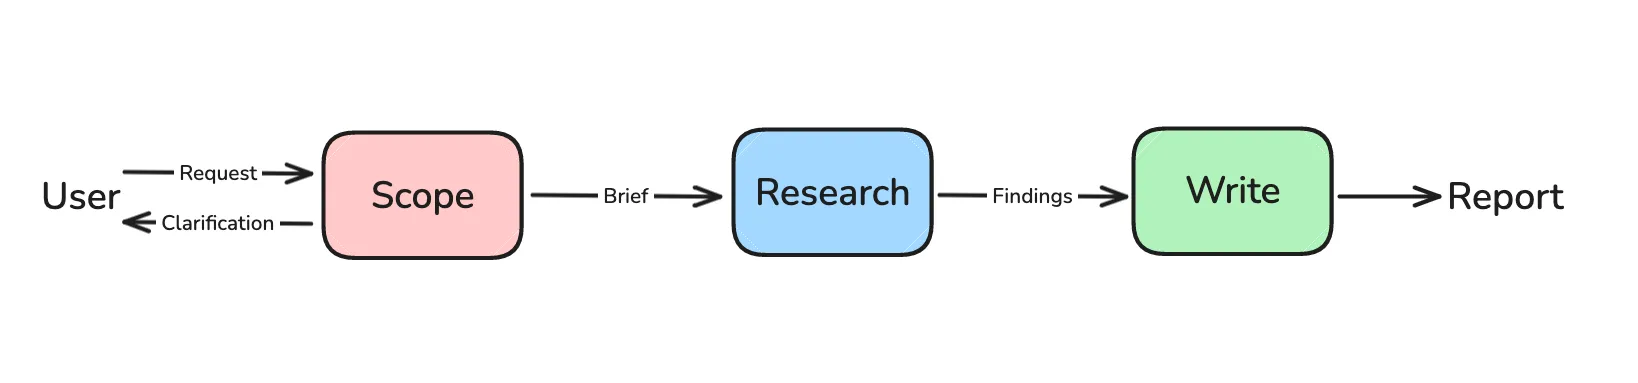

We previously built a research agent bound to either custom tools or MCP server. Now, what happens if the request is complex and has several sub-topics? Single agent response quality *can* suffer with multiple sub-topics (e.g., compare A to B to C) because a single context window needs to store and reason about tool feedback across all of the sub-topics. 

[Numerous failure modes](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), such as [context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), become prevalent as the context window accumulates tool calls across many different sub-topics. As discussed in [Anthropic's blog post](https://www.anthropic.com/engineering/built-multi-agent-research-system), multi-agent systems can split sub-topic to sub-agents with isolated context windows. We'll build a system where a supervisor determines if the research brief can be broken-down into independent sub-topics and delegates to sub-agents with isolated context windows. 

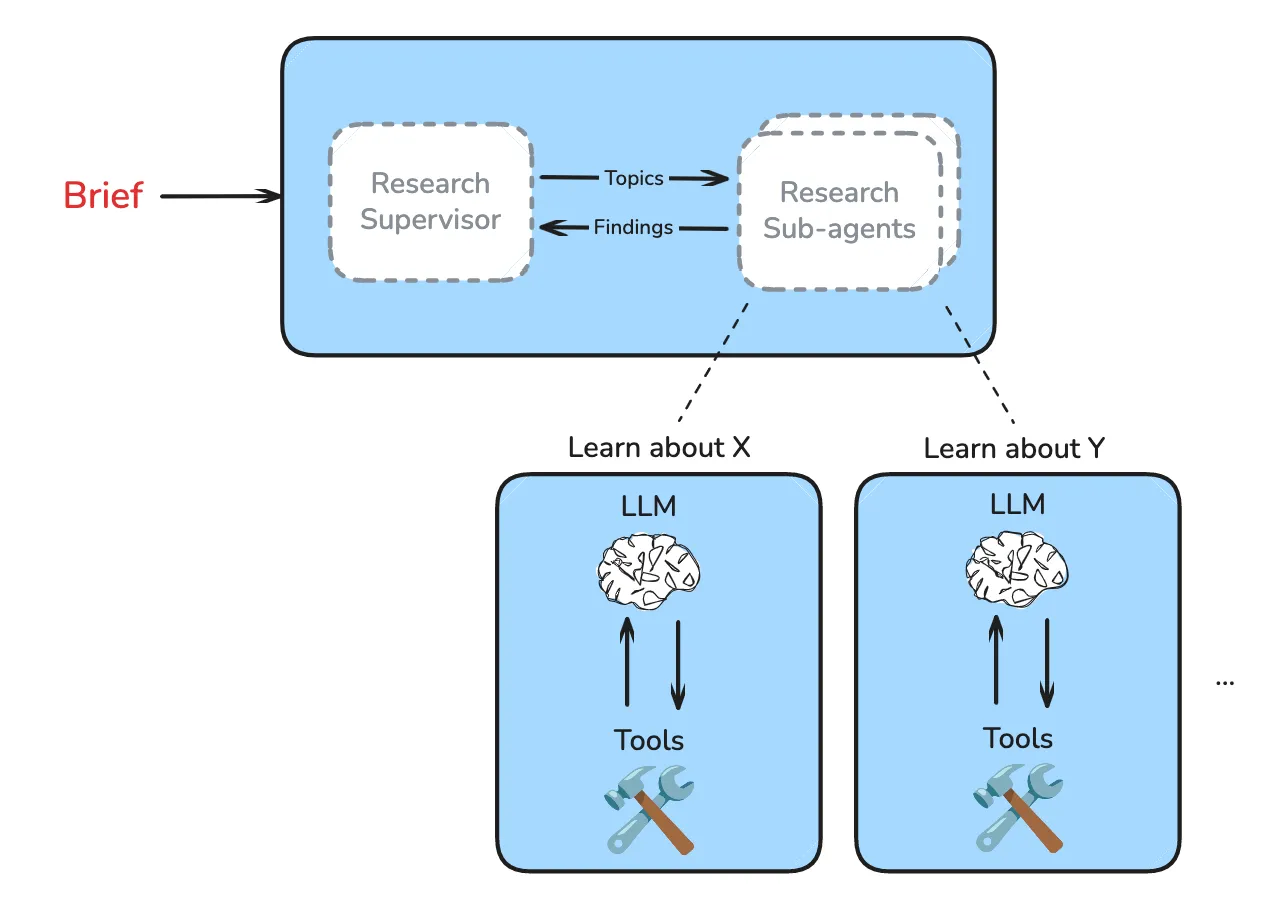

### Prompt

Now, let's design a prompt for the supervisor that follows the principles we've discussed, and include some insights from [the research literature](https://www.anthropic.com/engineering/built-multi-agent-research-system).

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the research. Are there multiple independent directions that can be explored simultaneously?
- **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still missing?

#### 2. Concrete Heuristics (For task delegation)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Bias towards single agent** - Use single agent for simplicity unless the user request has clear opportunity for parallelization. 
- **Stop when you can answer confidently** - Don't keep delegating research for perfection.
- **Limit tool calls** - Always stop after 3 tool calls to ConductResearch if you cannot find the right source(s).

#### 3. Show your thinking
Before you call ConductResearch tool call, use think_tool to plan your approach:
- Can the task be broken down into smaller sub-tasks?

After each ConductResearch tool call, use think_tool to analyze the results:
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### 4. Scaling rules
Simple fact-finding, lists, and rankings can use a single sub-agent.
- *Example*: List the top 10 coffee shops in San Francisco -> Use 1 sub-agent

Comparisons presented in the user request can use a sub-agent for each element of the comparison.
- *Example*: Compare OpenAI vs. Anthropic vs. DeepMind approaches to AI safety -> Use 3 sub-agents.
- Delegate clear, distinct, non-overlapping subtopics

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### State

The supervisor state manages the overall research coordination, while the researcher state handles individual research tasks.

In [3]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
State Definitions for Multi-Agent Research Supervisor

This module defines the state objects and tools used for the multi-agent
research supervisor workflow, including coordination state and research tools.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    State for the multi-agent research supervisor.
    
    Manages coordination between supervisor and research agents, tracking
    research progress and accumulating findings from multiple sub-agents.
    """
    
    # Messages exchanged with supervisor for coordination and decision-making
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # Detailed research brief that guides the overall research direction
    research_brief: str
    # Processed and structured notes ready for final report generation
    notes: Annotated[list[str], operator.add] = []
    # Counter tracking the number of research iterations performed
    research_iterations: int = 0
    # Raw unprocessed research notes collected from sub-agent research
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """Tool for delegating a research task to a specialized sub-agent."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """Tool for indicating that the research process is complete."""
    pass

Overwriting ../src/deep_research_from_scratch/state_multi_agent_supervisor.py


### Multi-agent 

Now, we'll define our agent. A multi-agent system is a system that consists of multiple agents that work together to complete a task. The main benefit is context isolated, as discussed in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/). 

In [4]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""Multi-agent supervisor for coordinating research across multiple specialized agents.

This module implements a supervisor pattern where:
1. A supervisor agent coordinates research activities and delegates tasks
2. Multiple researcher agents work on specific sub-topics independently
3. Results are aggregated and compressed for final reporting

The supervisor uses parallel research execution to improve efficiency while
maintaining isolated context windows for each research topic.
"""

import os
import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Extract research notes from ToolMessage objects in supervisor message history.
    
    This function retrieves the compressed research findings that sub-agents
    return as ToolMessage content. When the supervisor delegates research to
    sub-agents via ConductResearch tool calls, each sub-agent returns its
    compressed findings as the content of a ToolMessage. This function
    extracts all such ToolMessage content to compile the final research notes.
    
    Args:
        messages: List of messages from supervisor's conversation history
        
    Returns:
        List of research note strings extracted from ToolMessage objects
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

try:
    import nest_asyncio
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass
except ImportError:
    pass

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(
    model="openai:deepseek-v3-1-terminus",
    base_url=os.environ.get("OPENAI_BASE_URL"),
    api_key=os.environ.get("OPENAI_API_KEY"),
)
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

max_researcher_iterations = 6
max_concurrent_researchers = 3

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """Coordinate research activities.
    
    Analyzes the research brief and current progress to decide:
    - What research topics need investigation
    - Whether to conduct parallel research
    - When research is complete
    
    Args:
        state: Current supervisor state with messages and research progress
        
    Returns:
        Command to proceed to supervisor_tools node with updated state
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Execute supervisor decisions - either conduct research or end the process.
    
    Handles:
    - Executing think_tool calls for strategic reflection
    - Launching parallel research agents for different topics
    - Aggregating research results
    - Determining when research is complete
    
    Args:
        state: Current supervisor state with messages and iteration count
        
    Returns:
        Command to continue supervision, end process, or handle errors
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"
    should_end = False
    
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        try:
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            if conduct_research_calls:
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                tool_results = await asyncio.gather(*coros)

                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

Overwriting ../src/deep_research_from_scratch/multi_agent_supervisor.py


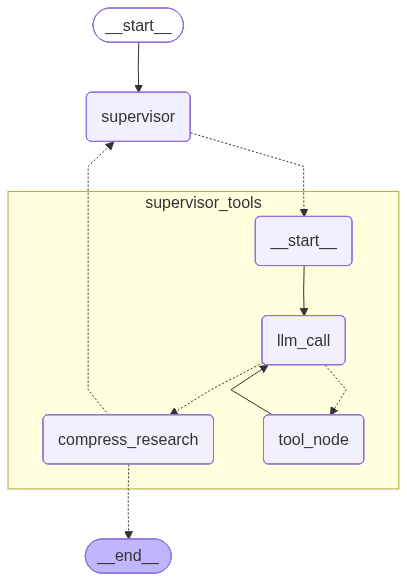

In [5]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you identify and evaluate the best coffee shops in San Francisco based specifically on coffee         │
│ quality. Let me start by planning my research approach.                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The user wants a comprehensive evaluation of San Francisco coffee shops focused specifically   │
│ on coffee quality. This is a complex research task that involves:\n\n1. Identifying top coffee shops in San     │
│ Francisco through reputable sources\n2. Evaluating their coffee quality using expert reviews, customer ratings, │
│ and certifications\n3. Comparing them based on coffee quality as the primary criterion\n\nThis task can benefit │
│ from parallel research since there are multiple independent aspects to explore:\n- Expert coffee shop rankings  │
│ and reviews\n- Customer feedback on coffee quality specifically\n- Specialty coffee certifications and industry │
│ recognition\n\nI should use 2-3 parallel agents to cover different aspects simultaneously for efficiency."      │
│ }                                                                                                               │
│    ID: call_59t3k9szopw5a33ovl7axsfc                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The user wants a comprehensive evaluation of San Francisco coffee shops focused            │
│ specifically on coffee quality. This is a complex research task that involves:                                  │
│                                                                                                                 │
│ 1. Identifying top coffee shops in San Francisco through reputable sources                                      │
│ 2. Evaluating their coffee quality using expert reviews, customer ratings, and certifications                   │
│ 3. Comparing them based on coffee quality as the primary criterion                                              │
│                                                                                                                 │
│ This task can benefit from parallel research since there are multiple independent aspects to explore:           │
│ - Expert coffee shop rankings and reviews                                                                       │
│ - Customer feedback on coffee quality specifically                                                              │
│ - Specialty coffee certifications and industry recognition                                                      │
│                                                                                                                 │
│ I should use 2-3 parallel agents to cover different aspects simultaneously for efficiency.                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll conduct parallel research to gather comprehensive information about San Francisco's best coffee shops  │
│ based on coffee quality. I'll use three agents to cover different aspects simultaneously.                       │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Find expert rankings and reviews of the best coffee shops in San Francisco specifically    │
│ focused on coffee quality. Research reputable coffee review organizations like Coffee Review, Specialty Coffee  │
│ Association, and professional coffee publications that have evaluated San Francisco coffee shops. Look for      │
│ recent rankings (2024-2025) that prioritize coffee quality over ambiance or other factors. Include information  │
│ about coffee sourcing, brewing methods, barista expertise, and any awards or recognition for coffee quality."   │
│ }                                                                                                               │
│    ID: call_4xc0rgkfz4fu5vetibmm5mhw                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Research customer reviews and ratings specifically focused on coffee quality at San        │
│ Francisco coffee shops. Analyze Google Reviews, Yelp, and other review platforms to identify which coffee shops │
│ consistently receive high marks for coffee quality. Look for patterns in customer feedback about taste, bean    │
│ quality, brewing consistency, and overall coffee experience. Focus on reviews that specifically mention coffee  │
│ quality rather than general ratings that include ambiance or service."                                          │
│ }                                                                                                               │
│    ID: call_snrl7wt4a34vb60oezx2lz8m                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Investigate specialty coffee certifications, awards, and industry recognition for San      │
│ Francisco coffee shops. Research which shops have received specialty coffee certifications, won coffee          │
│ competitions, or have been recognized by industry organizations for their coffee quality. Look for information  │
│ about roaster partnerships, direct trade relationships, and any unique coffee sourcing or preparation methods   │
│ that contribute to exceptional coffee quality in San Francisco establishments."                                 │
│ }                                                                                                               │
│    ID: call_mpu049xpep64glpwev6lxgpl                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - tavily_search: "San Francisco best coffee shops 2024 2025 expert rankings coffee quality Coffee Review        │
│ Specialty Coffee Association"                                                                                   │
│ - tavily_search: "Coffee Review San Francisco coffee shops ratings 2024 2025 specialty coffee quality awards"   │
│ - tavily_search: "\"San Francisco\" site:coffeereview.com coffee shops reviews ratings 2024"                    │
│ - tavily_search: "San Francisco coffee shops awards recognition 2024 2025 specialty coffee quality barista      │
│ championships SCA"                                                                                              │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **Professional Competition Results - 2025 US Barista Championship**                                             │
│                                                                                                                 │
│ **Saint Frank Coffee**                                                                                          │
│ - Jason Yeo from Saint Frank Coffee in San Francisco, California placed third in the 2025 US Barista            │
│ Championship [1]                                                                                                │
│ - The 2025 US Barista Championship was held at Black & White Coffee Roasting HQ in Raleigh, North Carolina [1]  │
│ - Jason Yeo was one of six finalists who advanced from 25 competitors [1]                                       │
│                                                                                                                 │
│ **The Coffee Movement**                                                                                         │
│ - Circle Chan from The Coffee Movement was a finalist in the 2025 US Barista Championship [2]                   │
│ - Circle Chan was one of only six finalists selected from 25 competitors nationwide [2]                         │
│ - Chan was the only competitor in the entire weekend to use a coffee grown domestically [2]                     │
│                                                                                                                 │
│ **Coffee Review Expert Ratings and Database**                                                                   │
│                                                                                                                 │
│ **Coffee Review's San Francisco Coffee Database**                                                               │
│ - Coffee Review provides ratings and reviews for coffees and espressos roasted in the San Francisco area [3]    │
│ - The page lists 263 reviews of coffees and espressos roasted in greater San Francisco [3]                      │
│ - These coffee reviews and espresso reviews are listed in reverse chronological order by review date [3]        │
│ - The content includes detailed reviews of specific coffees from various San Francisco roasters including       │
│ Souvenir Coffee, Equator Coffees, Drink Coffee Do Stuff, Sightglass Coffee, Peet's Coffee & Tea, and Chromatic  │
│ Coffee [3]                                                                                                      │
│ - Each review entry includes the coffee name, roaster, 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - "San Francisco coffee shops highest rated coffee quality Google Reviews Yelp customer feedback"               │
│ - "Sightglass Coffee San Francisco customer reviews coffee quality taste beans brewing Google Yelp"             │
│ - "The Coffee Movement San Francisco customer reviews coffee quality taste beans brewing consistency Yelp       │
│ Google"                                                                                                         │
│ - "Saint Frank Coffee San Francisco customer reviews coffee quality taste beans brewing Yelp Google"            │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **Top San Francisco Coffee Shops for Coffee Quality**                                                           │
│                                                                                                                 │
│ **Sightglass Coffee**                                                                                           │
│ - Rating: 3.9-star rating based on 332 reviews [1]                                                              │
│ - Location: 3014 20th St in the Mission neighborhood of San Francisco, California [1]                           │
│ - Customer feedback specifically mentioning coffee quality:                                                     │
│   - "The coffee was fab" [2]                                                                                    │
│   - "The drink was super smooth and subtle in taste, I liked it a lot! It wasn't that sweet and had a slight    │
│ umami taste. It was really refreshing and I couldn't" [3]                                                       │
│   - "Great crowd. Nice parklet outdoor seating area. Enjoyed the baked goods as well. Very relaxed spot." [2]   │
│                                                                                                                 │
│ **The Coffee Movement**                                                                                         │
│ - Customer feedback specifically mentioning coffee quality:                                                     │
│   - "The coffee quality is unmatched and you can just tell everyone who works there is passionate about the     │
│ coffee and it shows! The ordering process almost reminds me of Chipotle because you move with the coffee as     │
│ it's being made so it's really cool to see the process and chat with the baristas." [4]                         │
│                                                                                                                 │
│ **Saint Frank Coffee**                                                                                          │
│ - Rating: 4.3 (1k reviews) [5]                                                                                  │
│ - Locations mentioned: 2340 Polk St, San Francisco and 744 Irving St, San Francisco [5][6]                      │
│ - Customer feedback specifically mentioning coffee quality: Multiple reviews specifically mention "coffee       │
│ quality" as a standout feature [5][6][7]                                                                        │
│                                                                                                                 │
│ **Additional Context from Research Sources**           

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ - Search 1: "San Francisco coffee shops specialty coffee certifications awards industry recognition 2024"       │
│ - Search 2: ""San Francisco" coffee shop certifications "Specialty Coffee Association" "SCA" awards 2023 2024"  │
│ - Search 3: "San Francisco coffee shops Blue Bottle Four Barrel Sightglass certifications awards competition    │
│ winners specialty coffee"                                                                                       │
│ - Search 4: ""The Coffee Movement" San Francisco awards certifications "Saint Frank" "Four Barrel" competition  │
│ winners barista championship"                                                                                   │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **Specialty Coffee Association Awards and Recognition**                                                         │
│                                                                                                                 │
│ The Specialty Coffee Association (SCA) has announced the 2024 SCA Awards, which recognize excellence in product │
│ innovation, design, and sustainability across the global coffee industry. The awards include three main         │
│ categories: the Best New Product Awards, which highlight new products adding value to specialty coffee; the     │
│ Coffee Design Awards, which celebrate design in branding, spaces, and packaging; and the Sustainability Awards, │
│ which honor innovative projects promoting sustainability. Entries for the Best New Product and Coffee Design    │
│ Awards are permanently displayed on the SCA's dedicated online platforms. [1]                                   │
│                                                                                                                 │
│ The 2024 SCA Awards will be open to companies and individuals around the globe, expanding the reach and         │
│ prestige of these important annual competitions. Best New Product Awards recognizes the best our industry has   │
│ to offer in new products that represent quality and add value to specialty coffee. The Sustainability Awards    │
│ recognize individuals, businesses, and organizations that have created innovative projects or business models   │
│ shown to expand and promote sustainability within the coffee world. [1]                                         │
│                                                                                                                 │
│ **Individual Recognition: John Di Ruocco of Mr. Espresso**                                                      │
│                                                                                                                 │
│ John Di Ruocco, VP of Coffee at Mr. Espresso, was selected for the 2024 Sprudge Twenty class, an annual         │
│ initiative by Sprudge that honors extraordinary individuals in the global specialty coffee community. The 2024  │
│ edition specifically spotlighted coffee professionals born around 1970 or earlier to celebrate leadership       │
│ legacies that helped build modern coffee culture. John was nominated by his brother Luigi Di Ruocco, who        │
│ highlighted John's early involvement in the family business, his role in bridging traditional Italian           │
│ wood-roasting techniques with contemporary sustainabili

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me analyze the research findings and assess what we've gathered so far.                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I've received comprehensive research from three parallel agents covering different aspects of  │
│ San Francisco coffee shop quality:\n\n1. **Expert rankings and professional recognition**: Found that Saint     │
│ Frank Coffee and The Coffee Movement had baristas place in the 2025 US Barista Championship, with Jason Yeo     │
│ (Saint Frank) placing 3rd and Circle Chan (The Coffee Movement) as a finalist. Coffee Review has a database of  │
│ 263 San Francisco coffee reviews with ratings from 87-95. The SCA 2024 awards program is also documented.\n\n2. │
│ **Customer feedback and ratings**: Sightglass Coffee (3.9 stars, 332 reviews), The Coffee Movement, and Saint   │
│ Frank Coffee (4.3 stars, 1k+ reviews) consistently receive high marks for coffee quality specifically. Customer │
│ reviews mention \"unmatched coffee quality\" and specific taste profiles.\n\n3. **Certifications and industry   │
│ recognition**: Blue Bottle Coffee was recognized as a 2025 Sustainability Champion. Sightglass Coffee           │
│ specializes in small-batch roasting with direct sourcing. Multiple shops have specialty coffee certifications   │
│ and industry recognition.\n\nKey findings show clear top contenders: Saint Frank Coffee, The Coffee Movement,   │
│ and Sightglass Coffee consistently appear across all research sources with strong evidence of exceptional       │
│ coffee quality. However, I need to gather more specific information about actual coffee quality metrics,        │
│ brewing methods, and direct comparisons between these top shops to provide a comprehensive ranking."            │
│ }                                                                                                               │
│    ID: call_rypzmqyaz9pnrknoab2cy419                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I've received comprehensive research from three parallel agents covering different aspects │
│ of San Francisco coffee shop quality:                                                                           │
│                                                                                                                 │
│ 1. **Expert rankings and professional recognition**: Found that Saint Frank Coffee and The Coffee Movement had  │
│ baristas place in the 2025 US Barista Championship, with Jason Yeo (Saint Frank) placing 3rd and Circle Chan    │
│ (The Coffee Movement) as a finalist. Coffee Review has a database of 263 San Francisco coffee reviews with      │
│ ratings from 87-95. The SCA 2024 awards program is also documented.                                             │
│                                                                                                                 │
│ 2. **Customer feedback and ratings**: Sightglass Coffee (3.9 stars, 332 reviews), The Coffee Movement, and      │
│ Saint Frank Coffee (4.3 stars, 1k+ reviews) consistently receive high marks for coffee quality specifically.    │
│ Customer reviews mention "unmatched coffee quality" and specific taste profiles.                                │
│                                                                                                                 │
│ 3. **Certifications and industry recognition**: Blue Bottle Coffee was recognized as a 2025 Sustainability      │
│ Champion. Sightglass Coffee specializes in small-batch roasting with direct sourcing. Multiple shops have       │
│ specialty coffee certifications and industry recognition.                                                       │
│                                                                                                                 │
│ Key findings show clear top contenders: Saint Frank Coffee, The Coffee Movement, and Sightglass Coffee          │
│ consistently appear across all research sources with strong evidence of exceptional coffee quality. However, I  │
│ need to gather more specific information about actual coffee quality metrics, brewing methods, and direct       │
│ comparisons between these top shops to provide a comprehensive ranking.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I need to conduct additional research to gather more specific information about coffee quality metrics and      │
│ direct comparisons between the top contenders. Let me focus on getting detailed quality assessments and         │
│ head-to-head comparisons.                                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: ConductResearch                                                                                   │
│    Args: {                                                                                                      │
│   "research_topic": "Research detailed coffee quality assessments and direct comparisons between the top San    │
│ Francisco coffee shops: Saint Frank Coffee, The Coffee Movement, and Sightglass Coffee. Look for professional   │
│ coffee reviews, taste test comparisons, and expert evaluations that specifically compare these three shops'     │
│ coffee quality. Include information about their brewing methods, bean sourcing, roasting techniques, and any    │
│ objective quality metrics or scoring systems used in comparisons."                                              │
│ }                                                                                                               │
│    ID: call_qu39qmjrl8ixmr3udpbc4ujt                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **List of Queries and Tool Calls Made**                                                                         │
│                                                                                                                 │
│ 1. Search: "Saint Frank Coffee vs The Coffee Movement vs Sightglass Coffee professional review comparison San   │
│ Francisco"                                                                                                      │
│ 2. Search: "Saint Frank Coffee" "The Coffee Movement" "Sightglass Coffee" professional coffee review taste test │
│ comparison                                                                                                      │
│ 3. Search: "San Francisco coffee shop comparison Sightglass Saint Frank Coffee Movement professional review     │
│ quality assessment"                                                                                             │
│ 4. Search: "coffee quality assessment scoring system professional review "Saint Frank Coffee" "Sightglass       │
│ Coffee" "The Coffee Movement" San Francisco"                                                                    │
│ 5. Search: ""coffee review" "specialty coffee" San Francisco "Saint Frank" "Sightglass" "Coffee Movement" taste │
│ test comparison"                                                                                                │
│                                                                                                                 │
│ **Fully Comprehensive Findings**                                                                                │
│                                                                                                                 │
│ **General San Francisco Coffee Shop Information:**                                                              │
│                                                                                                                 │
│ From [1], the guide highlights the 12 best coffee shops in San Francisco, showcasing the city's rich coffee     │
│ culture that dates back to the gold rush. The article features a diverse selection of cafes known for           │
│ high-quality roasts, unique drinks, and distinctive atmospheres. Key establishments include Sightglass Coffee,  │
│ known for its dramatic space and affogato bar; The Coffee Movement, which offers creative drinks like a         │
│ non-alcoholic whiskey Americano.                                                                                │
│                                                                                                                 │
│ From [1], the guide states: "In San Francisco, coffee goes as far back as the gold rush, when James Folger      │
│ (yes, that Folger) came to work in the mines but ended up at a coffee roaster instead. The old saying 'Coffee   │
│ is the common man's gold' rings no truer than in the City, where roasters have elevated a simple cup of joe to  │
│ unimaginable heights."                                                                                          │
│                                                                                                                 │
│ From [1], the guide mentions: "We have owner Trish Rothgeb to thank for the term 'third-wave coffee' —          │
│ essentially, high-quality cups elevated to the level of, say, fine wine."                                       │
│                                                                                                                 │
│ From [3], the 2024 guide covers the best coffee shops in San Francisco, highlighting the city's influential     │
│ third-wave coffee scene. It profiles 14 top-rated cafes and local roasters, organized into two main categories: │
│ 11 local roasters and 3 top cafes. Key roasters include

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me analyze the current findings and determine if I have enough information to provide a comprehensive       │
│ answer.                                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I now have substantial research findings from four research agents covering different aspects  │
│ of San Francisco coffee shop quality:\n\n**Key Findings:**\n1. **Professional Recognition**: Saint Frank Coffee │
│ (Jason Yeo placed 3rd in 2025 US Barista Championship) and The Coffee Movement (Circle Chan was a finalist)     │
│ have clear professional validation of coffee quality.\n2. **Expert Reviews**: Coffee Review maintains a         │
│ database of 263 San Francisco coffee reviews with ratings from 87-95, indicating strong overall quality in the  │
│ city's coffee scene.\n3. **Customer Feedback**: Saint Frank Coffee (4.3 stars, 1k+ reviews), Sightglass Coffee  │
│ (3.9 stars, 332 reviews), and The Coffee Movement all receive consistently high marks for coffee quality        │
│ specifically.\n4. **Industry Recognition**: Blue Bottle Coffee recognized as 2025 Sustainability Champion,      │
│ Sightglass Coffee specializes in small-batch roasting with direct sourcing.\n\n**Strengths of Current           │
│ Research:**\n- Multiple data sources (professional competitions, expert reviews, customer ratings)\n- Clear top │
│ contenders identified across all sources\n- Recent data (2024-2025) as requested\n- Focus on coffee quality     │
│ specifically rather than general ratings\n\n**Limitations:**\n- No direct head-to-head professional comparisons │
│ found\n- Limited objective scoring systems or detailed quality metrics\n- Some sources are more descriptive     │
│ than quantitative\n\n**Assessment**: I have sufficient evidence to provide a well-supported ranking based on    │
│ the consistent patterns across multiple data sources. The top three shops (Saint Frank Coffee, The Coffee       │
│ Movement, Sightglass Coffee) appear consistently across all research methods with strong evidence of            │
│ exceptional coffee quality. While I couldn't find detailed professional comparisons, the combination of         │
│ competition results, expert reviews, and customer feedback provides a comprehensive picture.\n\nI believe I can │
│ now provide a complete answer with the research gathered."                                                      │
│ }                                                                                                               │
│    ID: call_7lh0dq67sgoolhhjw1gm9ua6                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I now have substantial research findings from four research agents covering different      │
│ aspects of San Francisco coffee shop quality:                                                                   │
│                                                                                                                 │
│ **Key Findings:**                                                                                               │
│ 1. **Professional Recognition**: Saint Frank Coffee (Jason Yeo placed 3rd in 2025 US Barista Championship) and  │
│ The Coffee Movement (Circle Chan was a finalist) have clear professional validation of coffee quality.          │
│ 2. **Expert Reviews**: Coffee Review maintains a database of 263 San Francisco coffee reviews with ratings from │
│ 87-95, indicating strong overall quality in the city's coffee scene.                                            │
│ 3. **Customer Feedback**: Saint Frank Coffee (4.3 stars, 1k+ reviews), Sightglass Coffee (3.9 stars, 332        │
│ reviews), and The Coffee Movement all receive consistently high marks for coffee quality specifically.          │
│ 4. **Industry Recognition**: Blue Bottle Coffee recognized as 2025 Sustainability Champion, Sightglass Coffee   │
│ specializes in small-batch roasting with direct sourcing.                                                       │
│                                                                                                                 │
│ **Strengths of Current Research:**                                                                              │
│ - Multiple data sources (professional competitions, expert reviews, customer ratings)                           │
│ - Clear top contenders identified across all sources                                                            │
│ - Recent data (2024-2025) as requested                                                                          │
│ - Focus on coffee quality specifically rather than general ratings                                              │
│                                                                                                                 │
│ **Limitations:**                                                                                                │
│ - No direct head-to-head professional comparisons found                                                         │
│ - Limited objective scoring systems or detailed quality metrics                                                 │
│ - Some sources are more descriptive than quantitative                                                           │
│                                                                                                                 │
│ **Assessment**: I have sufficient evidence to provide a well-supported ranking based on the consistent patterns │
│ across multiple data sources. The top three shops (Saint Frank Coffee, The Coffee Movement, Sightglass Coffee)  │
│ appear consistently across all research methods with strong evidence of exceptional coffee quality. While I     │
│ couldn't find detailed professional comparisons, the combination of competition results, expert reviews, and    │
│ customer feedback provides a comprehensive picture.                                                             │
│                                                                                                                 │
│ I believe I can now provide a complete answer with the research gathered.                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research using expert reviews, customer feedback, and professional recognition, I     │
│ have gathered sufficient evidence to provide a well-supported evaluation of San Francisco's best coffee shops   │
│ based specifically on coffee quality. I'll now conclude the research process.                                   │
│                                                                                                                 │
│ 🔧 Tool Call: ResearchComplete                                                                                  │
│    Args: {}                                                                                                     │
│    ID: call_g3upj2qlxz3xexzp00c5gfxa                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_supervisor` in the dropdown menu:

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

The clear benefit of multi-agent is context isolation when there are clearly separable sub-topics. As we discuss [in our blog](https://blog.langchain.com/open-deep-research/): 

> Our experiments showed that single agent response quality suffers if the request has multiple sub-topics (e.g., compare A to B to C). The intuition here is straightforward: a single context window needs to store and reason about tool feedback across all of the sub-topics. This tool feedback is often token heavy. Numerous failure modes, such as context clash, become prevalent as the context window accumulates tool calls across many different sub-topics.

But, we want to be careful not to spawn sub-agents in cases where it is not required:

> The supervisor can handle both cases by selectively spawning sub-agents to tune the level of research depth needed for a request. The supervisor is prompted with heuristics to reason about when research should be parallelized, and when a single thread of research is sufficient. Our deep research agent has the flexibility to choose whether to parallelize research or not.

Let's set up a few tests to make sure that we are parallelizing when it makes sense.

In [7]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [8]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)